# Scraping All Matches Played in FIFA World Cup History from Wikipedia

The FIFA World Cup, often simply called the World Cup, is an international association football competition contested by the senior men's national teams of the members of the Fédération Internationale de Football Association (FIFA), the sport's global governing body. The tournament has been held every four years since the inaugural tournament in 1930, except in 1942 and 1946 when it was not held because of the Second World War. The reigning champions are Argentina, who won their third title at the 2022 tournament (From Wikipedia).

**This history of the World Cup provides interesting data for analytics, however, getting the entire data can be challenging. This Notebook describes how to scrape Wikipedia for the world cup history data from 1930 to 2022**

### Let's Begin.....

There are two main datasets:
 - The summary data for each world cup year
 - The data on every match that has been played

### 2. Scraping All Matches Played At Each World Cup Year

At Wikipedia, information about each world cup tournament can be found at **https://en.wikipedia.org/wiki/{year}_FIFA_World_Cup**. The information for the individual matches can in the figure below where the red arrow is pointing  

For each match, we can grab details such as Date and Time the match was played, the home and away teams, the score line, the goal scorers for each team, the stadium, the attendance and the referee.

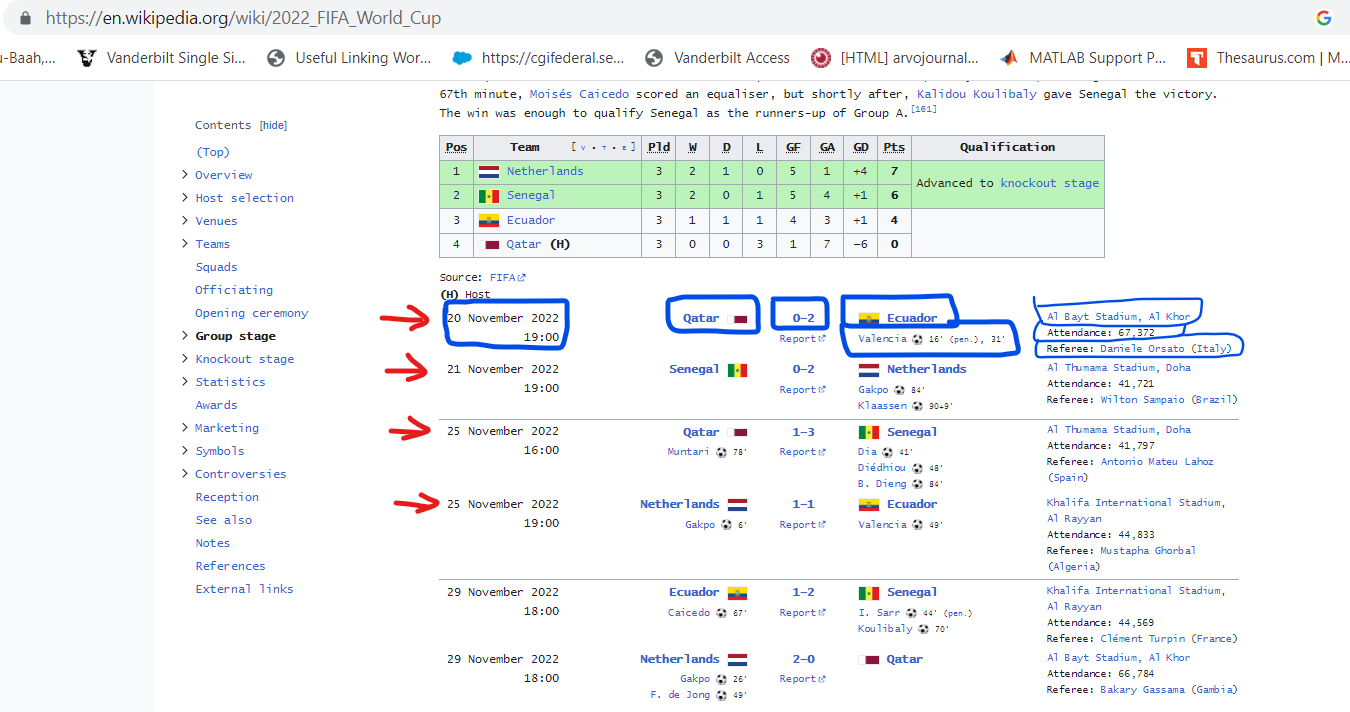

To get the information from this website, we will use python libraries **requests** to get the content and **beautifulsoup** to parse the content; numpy and pandas will be use for manipulation of numerical and table-like data. I found unicodedata.normalize to be very useful in getting text from scraped data. 

You can install the libraries using the following lines of code
 - pip install requests
 - pip install beautifulsoup4

After installing we will import the libraries...

In [1]:
import numpy as np
import pandas as pd
import requests
from bs4 import BeautifulSoup
from unicodedata import normalize

We will use request to get content and use beautifulsoup to parse contents 

In [2]:
year = 2022
r = requests.get(f'https://en.wikipedia.org/wiki/{year}_FIFA_World_Cup')
soup = BeautifulSoup(r.text, 'html.parser')

#### Now, how do we get the dat from the parsed information. At Wikipedia, each match information is tagged div.football.  We will use the tag to extract the data for the first match (use soup.find()) or all matches (use soup.find_all()) from the parsed information

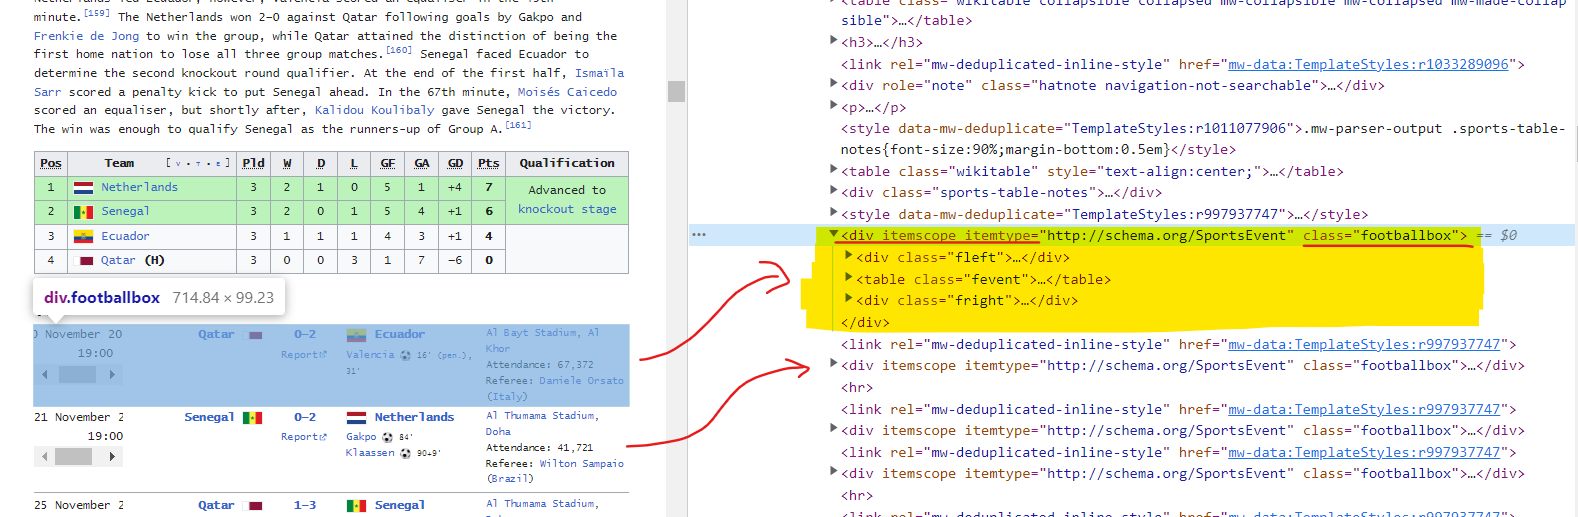

In [3]:
first_match = soup.find('div', {"class": "footballbox"})

#### Having extracted the match data, we can then extract each of the information we want such as Date, Time, Home and Away teams, score line etc. These information are tagged with "div.fdate", etc. The different information may be tagged differently. Right click on the page and select INSPECT to see the html code on the right. 

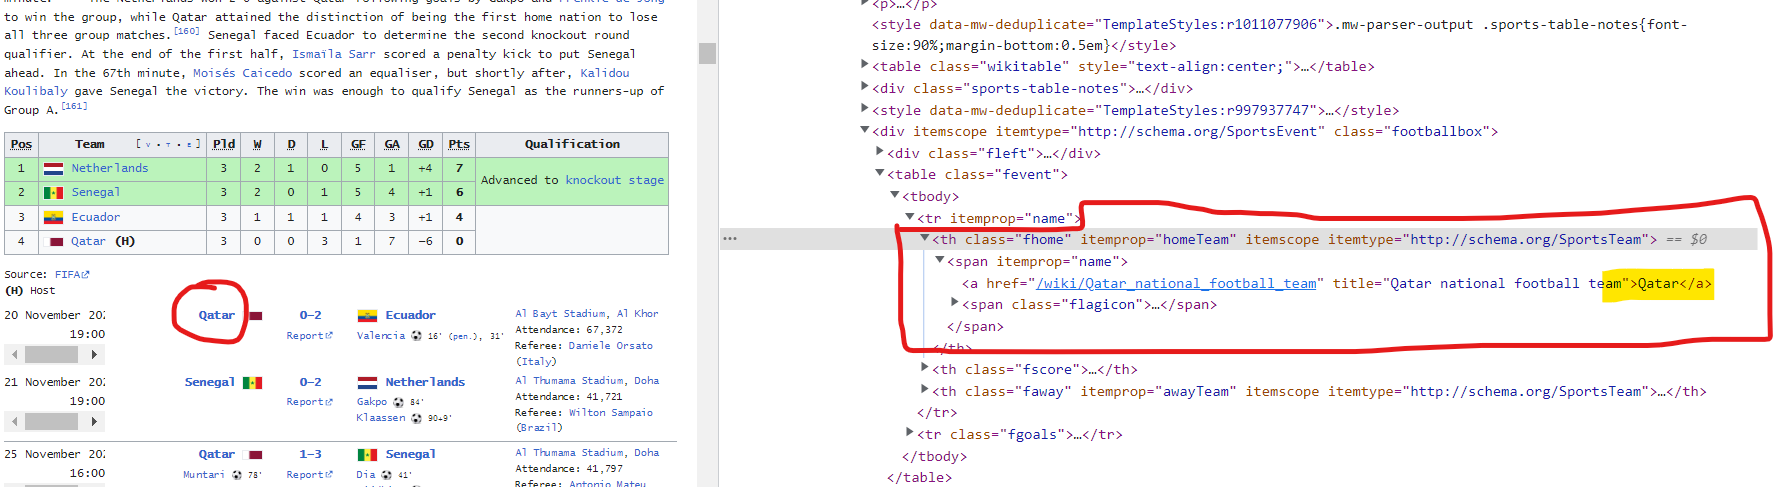

scraping the data for **date** and **time** of the first match....

In [4]:
fdate = normalize('NFKD', first_match.find('div', {"class": "fdate"}).text)
ftime = normalize('NFKD', first_match.find('div', {"class": "ftime"}).text)
print(f'The first FIFA 2022 World Cup match was played on {fdate} at {ftime}')

The first FIFA 2022 World Cup match was played on 20 November 2022 (2022-11-20) at 19:00


scraping the data for **home** and **away teams** of the first match....

In [5]:
fhome = normalize('NFKD', first_match.find('th', {"class": "fhome"}).text)
faway = normalize('NFKD', first_match.find('th', {"class": "faway"}).text)
print(f'The home and away teams for the first match at FIFA 2022 World Cup were {fhome} and {faway}')

The home and away teams for the first match at FIFA 2022 World Cup were Qatar  and  Ecuador


scraping the data for the **score line** of the first match....

In [6]:
fscore = normalize('NFKD', first_match.find('th', {"class": "fscore"}).text).split(' ')[0]
print(f'The final score was {fhome} {fscore} {faway}')

The final score was Qatar  0–2  Ecuador


### We can put everything together and get the history data for all the years from 1930 to 2022



set the number of year of world cup data

In [7]:
worldcup = [1930, 1934, 1938, 1950, 1954, 1958, 1962, 1966, 1970, 1974, 1978, 1982,
            1986, 1990, 1994, 1998, 2002, 2006, 2010, 2014, 2018, 2022]

set the columns for the data we want to extract

In [8]:
cols = ['Year', 'Date', 'Time', 'HomeTeam', 'AwayTeam', 'HomeScore', 'AwayScore', 'HomeScorers', 'AwayScorers', 'ExtraTime',
        'Penalty', 'HomePenaltyScore', 'AwayPenaltyScore', 'Stadium', 'Location', 'Attendance', 'Referee']

created this function **find_delimiter** to take a string and determine whether certain delimiters are present. 
The delimiters are those found in the scraped data and will help in cleaning the data





In [9]:
def find_delimiter(fscore):
    dts = ['–', ',', ':', '-']
    n = 0
    while fscore.find(dts[n]) == -1:
        n += 1
    return dts[n]

#### Start Scraping 

In [10]:
# initiate a list to append data
MatchData = []

# iterate through each year
for year in worldcup:
    
    # some of the world cup years have different websites for group and knockout data. 
    # Here are those with different websites
    
    if (year < 1970) or (year > 1990): # these worldcups have the same website for group and knockout matches
        gps = []
    elif year == 1970:
        gps = [1, 2, 3, 4]
    elif any([year == 1974, year == 1978]):
        gps = [1, 2, 3, 4, 'A', 'B']
    elif year == 1982:
        gps = [1, 2, 3, 4, 5, 6, 'A', 'B', 'C', 'D']
    elif any([year == 1986, year == 1990]):
        gps = ['A', 'B', 'C', 'D', 'E', 'F']

    # SCRAPE GROUP STAGES FOR SOME WORLD CUPS
    for gp in gps:

        g = requests.get(f'https://en.wikipedia.org/wiki/{year}_FIFA_World_Cup_Group_{gp}')
        soup = BeautifulSoup(g.text, 'html.parser')
        
         # get all matches
        all_matches = soup.find_all('div', {"class": "footballbox"})

        for cur_match in all_matches:
            datenow = normalize('NFKD', cur_match.find('div', {"class": "fdate"}).text)
            timenow = normalize('NFKD', cur_match.find('div', {"class": "ftime"}).text)
            
            fscore = normalize('NFKD', cur_match.find('th', {"class": "fscore"}).text).split(' ')[0]
            delimiter = find_delimiter(fscore)
            fscore = fscore.split(delimiter)
            hscore = int(fscore[0])
            ascore = int(fscore[1])
            
            ## for group games, there are no extra time and penalties
            extratime = 0
            penalty = 0
            homepen = 0
            awaypen = 0
            
            fhome = normalize('NFKD', cur_match.find('th', {"class": "fhome"}).text).strip()
            faway = normalize('NFKD', cur_match.find('th', {"class": "faway"}).text).strip()
            fstad = normalize('NFKD', cur_match.find('div', {"class": "fright"}).contents[0].text).split(',')[0]
            floc = normalize('NFKD', cur_match.find('div', {"class": "fright"}).contents[0].text).split(',')[1]
            fhgoal = normalize('NFKD', cur_match.find('td', {"class": "fhgoal"}).text)
            fagoal = normalize('NFKD', cur_match.find('td', {"class": "fagoal"}).text)
            fattend = normalize('NFKD', cur_match.find('div', {"class": "fright"}).contents[1].text).split(': ')[1]
            fref = normalize('NFKD', cur_match.find('div', {"class": "fright"}).contents[2].text).split(': ')[1]

            MatchData.append([year, datenow, timenow, fhome, faway, hscore, ascore, fhgoal, fagoal, extratime, penalty,
                              homepen, awaypen, fstad, floc, fattend, fref])


    # KNOCKOUT STAGES FOR THOSE WORLD CUPS ABOVE OR ALL STAGES FOR world cups before 1970 and after 1990
    r = requests.get(f'https://en.wikipedia.org/wiki/{year}_FIFA_World_Cup')
    soup = BeautifulSoup(r.text, 'html.parser')

  # get all matches
    all_matches = soup.find_all('div', {"class": "footballbox"})

    for cur_match in all_matches:             
        score_all = normalize('NFKD', cur_match.find('th', {"class": "fscore"}).text).split(' ')
        fscore = score_all[0]
        extratime = 0
        homepen = 0
        awaypen = 0
        penalty = 0
        
        # change extratime, homepen and awaypen if extratime was played
        if len(score_all) == 2:
            if score_all[1] == '(a.e.t.)':
                extratime = 1
                matchgoals = cur_match.find_all('tr', {"class": "fgoals"})
                if len(matchgoals) == 1: # extra time was played but no penalties
                    homepen = 0
                    awaypen = 0
                    penalty = 0
                else:
                    # extra time was played with penalties
                    penalty = 1
                    penscore = normalize('NFKD', matchgoals[1].find('th').text)
                    delimiter = find_delimiter(penscore)
                    penscore = penscore.split(delimiter)
                    homepen = int(penscore[0])
                    awaypen = int(penscore[1])
                        
        if fscore != 'w/o[a]':  # match was not a walkover [This happened once in 1938 between Sweden and Austria]
            datenow = normalize('NFKD', cur_match.find('div', {"class": "fdate"}).text)
            timenow = normalize('NFKD', cur_match.find('div', {"class": "ftime"}).text)
            delimiter = find_delimiter(fscore)
            fscore = fscore.split(delimiter)
            hscore = int(fscore[0])
            ascore = int(fscore[1])
            fattend = normalize('NFKD', cur_match.find('div', {"class": "fright"}).contents[1].text).split(': ')[1]
            fref = normalize('NFKD', cur_match.find('div', {"class": "fright"}).contents[2].text).split(': ')[1]
            fhome = normalize('NFKD', cur_match.find('th', {"class": "fhome"}).text).strip()
            faway = normalize('NFKD', cur_match.find('th', {"class": "faway"}).text).strip()
            fstad = normalize('NFKD', cur_match.find('div', {"class": "fright"}).contents[0].text).split(',')[0]
            floc = normalize('NFKD', cur_match.find('div', {"class": "fright"}).contents[0].text).split(',')[1]
            fhgoal = normalize('NFKD', cur_match.find('td', {"class": "fhgoal"}).text)
            fagoal = normalize('NFKD', cur_match.find('td', {"class": "fagoal"}).text)


            MatchData.append([year, datenow, timenow, fhome, faway, hscore, ascore, fhgoal, fagoal, 
                              extratime, penalty, homepen, awaypen, fstad, floc, fattend, fref])
    
    # print year when done
    print(f'{year}')


1930
1934
1938
1950
1954
1958
1962
1966
1970
1974
1978
1982
1986
1990
1994
1998
2002
2006
2010
2014
2018
2022


#### view complete dataframe

In [11]:
df = pd.DataFrame(MatchData, columns=cols)
df.head()

,Year,Date,Time,HomeTeam,AwayTeam,HomeScore,AwayScore,HomeScorers,AwayScorers,ExtraTime,Penalty,HomePenaltyScore,AwayPenaltyScore,Stadium,Location,Attendance,Referee
0,1930,13 July 1930,15:00 UYT (UTC−03:30),France,Mexico,4,1,"L. Laurent 19'Langiller 40'Maschinot 43', 87'",Carreño 70',0,0,0,0,Estadio Pocitos,Montevideo,"4,444",Domingo Lombardi (Uruguay)
1,1930,15 July 1930,16:00 UYT (UTC−03:30),Argentina,France,1,0,Monti 81',,0,0,0,0,Estadio Parque Central,Montevideo,"23,409",Almeida Rêgo (Brazil)
2,1930,16 July 1930,14:45 UYT (UTC−03:30),Chile,Mexico,3,0,"Vidal 3', 65'M. Rosas 52' (o.g.)",,0,0,0,0,Estadio Parque Central,Montevideo,"9,249",Henri Christophe (Belgium)
3,1930,19 July 1930,12:50 UYT (UTC−03:30),Chile,France,1,0,Subiabre 67',,0,0,0,0,Estadio Centenario,Montevideo,"2,000",Anibal Tejada (Uruguay)
4,1930,19 July 1930,15:00 UYT (UTC−03:30),Argentina,Mexico,6,3,"Stábile 8', 17', 80'Zumelzú 12', 55'Varall...","M. Rosas 42' (pen.), 65'Gayón 75'",0,0,0,0,Estadio Centenario,Montevideo,"42,100",Ulises Saucedo (Bolivia)


In [12]:
print(f'The shape of the dataframe is {df.shape}')

The shape of the dataframe is (964, 17)


#### save dataframe into csv file

In [13]:
df.to_csv('WorldCupMatches.csv')